# Chapter 5 卷积神经网络

## 5.1 卷积

In [115]:
import torch
import torch.nn as nn

In [116]:
class Conv2D_V0(nn.Module):
    def __init__(self, kernel_size, weight_attr=None):
        super(Conv2D_V0, self).__init__()
        if weight_attr is None:
            self.weight = nn.Parameter(data=nn.init.constant_(torch.empty(kernel_size, kernel_size), val=1.))
        else:
            self.weight = weight_attr
    
    def forward(self, X):
        """
        input:
            X: shape=[B, N, M]
        """
        u, v = self.weight.shape
        output = torch.zeros([X.shape[0], X.shape[1] - u + 1, X.shape[2] - v + 1])
        for i in range(output.shape[1]):
            for j in range(output.shape[2]):
                output[:, i, j] = torch.sum(X[:, i:i+u, j:j+v] * self.weight, dim=[1, 2])
        return output

In [117]:
torch.manual_seed(100)
inputs = torch.randn([2, 3, 3])
conv2d = Conv2D_V0(kernel_size=2)
outputs = conv2d(inputs)
print(f"input: {inputs}, \noutput: {outputs}")

input: tensor([[[ 0.1268,  1.3564, -0.0247],
         [-0.8466,  0.0293, -0.5721],
         [-1.2546,  0.0486,  0.2753]],

        [[-2.1550, -0.7116,  0.0575],
         [ 0.6263, -1.7736, -0.2205],
         [ 2.7467, -1.0480,  1.1239]]]), 
output: tensor([[[ 0.6659,  0.7890],
         [-2.0233, -0.2189]],

        [[-4.0138, -2.6481],
         [ 0.5514, -1.9181]]], grad_fn=<CopySlices>)


In [118]:
class Conv2d(nn.Module):
    def __init__(self, kernel_size, stride=1, padding=0, weight_attr=None):
        super(Conv2d, self).__init__()
        if weight_attr is None:
            self.weight = nn.Parameter(data=nn.init.constant_(torch.empty(kernel_size, kernel_size), val=1.))
        else:
            self.weight = nn.Parameter(data=weight_attr)
        self.stride = stride
        self.padding = padding
    
    def forward(self, X):
        new_X = torch.zeros([X.shape[0], X.shape[1] + self.padding * 2, X.shape[2] + self.padding * 2])
        new_X[:, self.padding:self.padding + X.shape[1], self.padding:self.padding + X.shape[2]] = X
        u, v = self.weight.shape
        output_h = (new_X.shape[1] - u) // self.stride + 1
        output_w = (new_X.shape[2] - v) // self.stride + 1
        output = torch.zeros([X.shape[0], output_h, output_w])
        for i in range(output.shape[1]):
            for j in range(output.shape[2]):
                output[:, i, j] = torch.sum(new_X[:, i * self.stride:i * self.stride + u, j * self.stride:j * self.stride + v]
                                            * self.weight, dim=[1, 2])
        
        return output

In [119]:
inputs = torch.randn([2, 8, 8])
conv2d_padding = Conv2d(kernel_size=3, padding=1)
outputs = conv2d_padding(inputs)
print(f"1: input shape: {inputs.shape}, output shape: {outputs.shape}")
conv2d_stride = Conv2d(kernel_size=3, stride=2, padding=1)
outputs = conv2d_stride(inputs)
print(f"2: input shape: {inputs.shape}, output shape: {outputs.shape}")

1: input shape: torch.Size([2, 8, 8]), output shape: torch.Size([2, 8, 8])
2: input shape: torch.Size([2, 8, 8]), output shape: torch.Size([2, 4, 4])


torch.Size([1, 28, 28])
inputs: tensor([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   3.,
            0.,   0.,   4.,   2.,   0.,  11.,   0.,   0.,  14.,   1.,   0.,
           19.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  12.,   0.,
            0.,   7.,   0.,   1.,  10.,   0.,   2.,   2.,  16.,   0.,   3.,
            3.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   8.,   0.,
            8.,   0.,   0.,   8.,   0.,   0.,  19.,   0.,   0.,   1.,  21.,
            0.,   4.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
            0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,  11.,   0.,   0.,
           10.,   3.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  13.,   0.,  15.,
           10.,  26.,  34.,  17.,  77., 181., 178.,  35.,   4.,   0.,   0.,
            0.,   0.

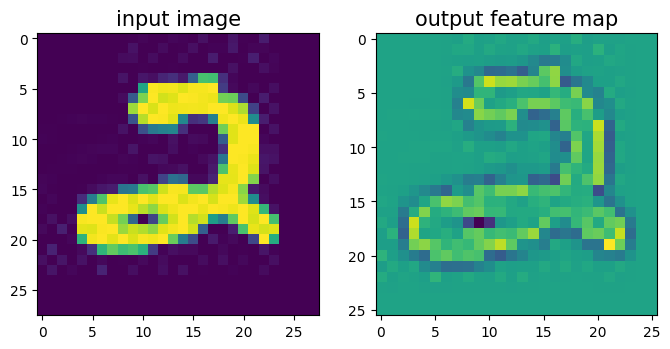

In [120]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

img = Image.open('./dataset/number.jpg')
img = img.convert('L').resize((28, 28))
w = torch.tensor([[-1., -1., -1.], [-1., 8., -1.], [-1., -1., -1.]])
conv = Conv2d(kernel_size=3, stride=1, padding=0, weight_attr=w)

inputs = np.asarray(img).astype('float32')
inputs = torch.tensor(inputs)
inputs = torch.unsqueeze(inputs, dim=0)
print(inputs.shape)
print(f'inputs: {inputs}')
outputs = conv(inputs)
print(f'output: {outputs}')
outputs = outputs.detach().numpy()
plt.figure(figsize=(8, 4))
f = plt.subplot(121)
f.set_title('input image', fontsize=15)
plt.imshow(img)
f = plt.subplot(122)
f.set_title('output feature map', fontsize=15)
plt.imshow(outputs.squeeze())
plt.show()

## 5.2 基础算子

In [121]:
class Conv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 weight_attr=None, bias_attr=None):
        super(Conv2D, self).__init__()
        if weight_attr is None:
            self.weight = nn.Parameter(data=nn.init.constant_(torch.empty(out_channels, in_channels, kernel_size, kernel_size), val=1.))
        else:
            self.weight = nn.Parameter(data=weight_attr(torch.empty(out_channels, in_channels, kernel_size, kernel_size)))
        self.bias = nn.Parameter(data=torch.empty(out_channels, 1))
        self.stride = stride
        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels
    
    def single_forward(self, X, weight):
        new_X = torch.zeros([X.shape[0], X.shape[1] + self.padding * 2, X.shape[2] + self.padding * 2])
        new_X[:, self.padding:self.padding + X.shape[1], self.padding:self.padding + X.shape[2]] = X
        u, v = weight.shape
        output_h = (new_X.shape[1] - u) // self.stride + 1
        output_w = (new_X.shape[2] - v) // self.stride + 1
        output = torch.zeros([X.shape[0], output_h, output_w])
        for i in range(output.shape[1]):
            for j in range(output.shape[2]):
                output[:, i, j] = torch.sum(new_X[:, i * self.stride:i * self.stride + u, j * self.stride:j * self.stride + v]
                                            * weight, dim=[1, 2])
        return output
    
    def multi2single_forward(self, inputs, weight, b):
        """
        输入：
        - inputs: [B, D, M, N]
        - weight: [D, U, V]
        - b: [1]
        """
        return torch.sum(torch.stack([self.single_forward(inputs[:, i, :, :], weight[i]) for i in range(self.in_channels)], dim=1), dim=1) + b
    
    def multi2multi_forward(self, inputs, weights, bias):
        """
        输入：
        - inputs: [B, D, M, N]
        - weight: [P, D, U, V]
        - b: [P, 1]
        """
        return torch.stack([self.multi2single_forward(inputs, w, b) for w, b in zip(weights, bias)], dim=1)
    
    def forward(self, inputs):
        return self.multi2multi_forward(inputs, self.weight, self.bias)

In [122]:
class Pool2D(nn.Module):
    def __init__(self, size=(2, 2), mode='max', stride=1):
        super(Pool2D, self).__init__()
        self.mode = mode
        self.h, self.w = size
        self.stride = stride
    
    def forward(self, X):
        output_h = (X.shape[2] - self.h) // self.stride + 1
        output_w = (X.shape[3] - self.w) // self.stride + 1
        output = torch.zeros(size=[X.shape[0], X.shape[1], output_h, output_w])
        for i in range(output.shape[2]):
            for j in range(output.shape[3]):
                if self.mode == 'max':
                    output[:, :, i, j] = X[:, :, i * self.stride:i * self.stride + self.h,
                                                     j * self.stride:j * self.stride + self.w].max()
                elif self.mode == 'avg':
                    output[:, :, i, j] = X[:, :, i * self.stride:i * self.stride + self.h,
                                                     j * self.stride:j * self.stride + self.w].mean()
        return output


## 5.3 LeNet MNIST 任务（有点问题）

In [123]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', data_home='./dataset/MNIST')

KeyboardInterrupt: 

In [11]:
data = mnist['data'].values
target = mnist['target'].values
train_set, dev_set, test_set = [data[:60000], target[:60000]], [data[60000:65000], target[60000:65000]], [data[65000:], target[65000:]]
train_images, train_labels = train_set[0][:1000], train_set[1][:1000]
dev_images, dev_labels = dev_set[0][:200], dev_set[1][:200]
test_images, test_labels = test_set[0][:200], test_set[1][:200]

In [ ]:
image, label = train_set[0][0], train_set[1][0]
image, label = np.array(image).astype('float32'), int(label)

image = np.reshape(image, [28, 28])
image = Image.fromarray(image.astype('uint8'), mode='L')
plt.figure(figsize=(5, 5))
plt.imshow(image)

### 数据预处理

In [78]:
from torchvision import transforms
preprocess = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])

In [55]:
import random
from torch.utils.data import Dataset, DataLoader

class MNISTDataset(Dataset):
    def __init__(self, dataset, transforms, mode='train') -> None:
        super(MNISTDataset, self).__init__()
        self.mode = mode
        self.dataset = dataset
        self.transforms = transforms
        self.index_list = list(range(len(self.dataset[0])))
    
    def __getitem__(self, index):
        index = self.index_list[index]
        image, label = self.dataset[0][index], self.dataset[1][index]
        image, label = np.array(image).astype('float32'), int(label)
        image = np.reshape(image, [28, 28])
        image = Image.fromarray(image.astype('uint8'), mode='L')
        # image = self.transforms(image)
        image = transforms.Resize(32)(image)
        image = transforms.PILToTensor()(image).float()
        image = transforms.Normalize(mean=[255.0/2], std=[255.0/2])(image)

        return image, label
    
    def __len__(self):
        return len(self.dataset[0])

In [56]:
random.seed(0)

train_dataset = MNISTDataset(dataset=train_set, transforms=preprocess, mode='train')
test_dataset = MNISTDataset(dataset=test_set, transforms=preprocess, mode='test')
dev_dataset = MNISTDataset(dataset=test_set, transforms=preprocess, mode='dev')

In [57]:
import torch.nn.functional as F

class Model_LeNet(nn.Module):
    def __init__(self, in_channels, num_classes=10) -> None:
        super(Model_LeNet, self).__init__()
        self.conv1 = Conv2D(in_channels=in_channels, out_channels=6, kernel_size=5, weight_attr=torch.nn.init.xavier_normal_)
        self.pool2 = Pool2D(size=(2, 2), mode='max', stride=2)
        self.conv3 = Conv2D(in_channels=6, out_channels=16, kernel_size=5, weight_attr=torch.nn.init.xavier_normal_)
        self.pool4 = Pool2D(size=(2, 2), mode='avg', stride=2)
        self.conv5 = Conv2D(in_channels=16, out_channels=120, kernel_size=5, weight_attr=torch.nn.init.xavier_normal_)
        self.linear6 = nn.Linear(120, 84)
        self.linear7 = nn.Linear(84, num_classes)
    
    def forward(self, x):
        output = F.relu(self.conv1(x))
        output = self.pool2(output)
        output = F.relu(self.conv3(output))
        output = self.pool4(output)
        output = F.relu(self.conv5(output))
        output = torch.squeeze(output, dim=[2, 3])
        output = F.relu(self.linear6(output))
        output = self.linear7(output)
        return output

In [ ]:
inputs = np.random.randn(*[1, 6, 28, 28])
print(inputs)
inputs = inputs.astype('float32')
inputs = torch.tensor(inputs)
model = Pool2D(size=(2, 2), mode='max', stride=2)
outputs = model(inputs)
print(outputs)

In [ ]:
inputs = np.random.randn(*[1, 1, 32, 32])
inputs = inputs.astype('float32')

model = Model_LeNet(in_channels=1, num_classes=10)
print(model.modules())
model_modules = [x for x in model.modules()]
print(model_modules)
x = torch.tensor(inputs)
for name, item in model.named_children():
    try:
        x = item(x)
    except:
        x = torch.reshape(x, [x.shape[0], -1])
        x = item(x)
    
    if sum(1 for p in item.parameters()) == 2:
        print(name, x.shape)
        for p in item.parameters():
            print(p.shape)
    else:
        print(name, x.shape)


In [ ]:
import torch.optim as opt
from pre_methods import RunnerV3, Accuracy

torch.manual_seed(100)
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)

model = Model_LeNet(in_channels=1, num_classes=10)
optimzer = opt.SGD(lr=0.1, params=model.parameters())
loss_fn = F.cross_entropy
metric = Accuracy(is_logist=True)

runner = RunnerV3(model, optimizer=optimzer, loss_fn=loss_fn, metric=metric)
runner.train(train_dataloader=train_loader, val_dataloader=dev_loader, num_epochs=5, log_steps=15, eval_steps=15, save_dir='./checkpoint_LeNet_MNIST')

## 5.4 ResNet MNIST